In [1]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split

### classifier 
from catboost import CatBoostClassifier 

import warnings
warnings.filterwarnings('ignore')

In [2]:
def side_by_side(*objs, **kwds):
    from pandas.io.formats.printing import adjoin
    space = kwds.get('space', 4)
    reprs = [repr(obj).split('\n') for obj in objs]
    print (adjoin(space, *reprs))
    print()
    return

# **<span style="color:	#D400D7;">1. Memproses dan memahami dataset</span>**

In [3]:
airlineDF = pd.read_csv("C:/Work/Data Science/My portofolio/Airlines Customer Satisfaction/Invistico_Airline.csv")

In [4]:
airlineDF.shape

(129880, 23)

In [5]:
side_by_side(airlineDF.isnull().sum(), airlineDF.count()) # Menghitung berapa Jumlah kolom dan yang mengandung nilai Null

satisfaction                           0    satisfaction                         129880
Gender                                 0    Gender                               129880
Customer Type                          0    Customer Type                        129880
Age                                    0    Age                                  129880
Type of Travel                         0    Type of Travel                       129880
Class                                  0    Class                                129880
Flight Distance                        0    Flight Distance                      129880
Seat comfort                           0    Seat comfort                         129880
Departure/Arrival time convenient      0    Departure/Arrival time convenient    129880
Food and drink                         0    Food and drink                       129880
Gate location                          0    Gate location                        129880
Inflight wifi service           

In [6]:
airlineDF[['Class']].groupby(['Class']).size()

Class
Business    62160
Eco         58309
Eco Plus     9411
dtype: int64

# **<span style="color:	#D400D7;">2. Pengkodean Label</span>**

In [7]:
## Kolom kepuasan - label encoding 
satisfaction_mapping = {"satisfied": 1, "dissatisfied": 0}
airlineDF['satisfaction'] = airlineDF['satisfaction'].map(satisfaction_mapping) 

## Kolom Gender - label encoding  
gender_mapping = {"Female": 1, "Male": 0}
airlineDF['Gender'] = airlineDF['Gender'].map(gender_mapping) 

## Kolom tipe Customer - label encoding  
customer_type_mapping = {"Loyal Customer": 1, "disloyal Customer": 0}
airlineDF['Customer Type'] = airlineDF['Customer Type'].map(customer_type_mapping) 

## kolom tipe travel - label encoding  
travel_type_mapping = {"Business travel": 2, "Personal Travel": 1}
airlineDF['Type of Travel'] = airlineDF['Type of Travel'].map(travel_type_mapping)  

## Kolom Class - label encoding  
class_mapping = {"Business": 3, "Eco Plus": 2, "Eco": 1}
airlineDF['Class'] = airlineDF['Class'].map(class_mapping)  

# **<span style="color:	#D400D7;">3. Mengkategorikan Features</span>**

In [8]:
airlineDF.nunique() ## Berapa banyak Nilai unik yang dimiliki oleh masing-masing features

satisfaction                            2
Gender                                  2
Customer Type                           2
Age                                    75
Type of Travel                          2
Class                                   3
Flight Distance                      5398
Seat comfort                            6
Departure/Arrival time convenient       6
Food and drink                          6
Gate location                           6
Inflight wifi service                   6
Inflight entertainment                  6
Online support                          6
Ease of Online booking                  6
On-board service                        6
Leg room service                        6
Baggage handling                        5
Checkin service                         6
Cleanliness                             6
Online boarding                         6
Departure Delay in Minutes            466
Arrival Delay in Minutes              472
dtype: int64

In [9]:
airlineDF.columns

Index(['satisfaction', 'Gender', 'Customer Type', 'Age', 'Type of Travel',
       'Class', 'Flight Distance', 'Seat comfort',
       'Departure/Arrival time convenient', 'Food and drink', 'Gate location',
       'Inflight wifi service', 'Inflight entertainment', 'Online support',
       'Ease of Online booking', 'On-board service', 'Leg room service',
       'Baggage handling', 'Checkin service', 'Cleanliness', 'Online boarding',
       'Departure Delay in Minutes', 'Arrival Delay in Minutes'],
      dtype='object')

In [10]:
cat_features = ['Gender', 'Customer Type', 'Type of Travel', 'Class', 'Seat comfort',
               'Departure/Arrival time convenient', 'Food and drink', 'Gate location',
               'Inflight wifi service', 'Inflight entertainment', 'Online support',
               'Ease of Online booking', 'On-board service', 'Leg room service',
               'Baggage handling', 'Checkin service', 'Cleanliness', 'Online boarding']

target = 'satisfaction'

# **<span style="color:	#D400D7;">4. Mengecek Keseimbangan Kelas</span>**

Counts of each class
1    71087
0    58793
Name: satisfaction, dtype: int64


(129880, 23)

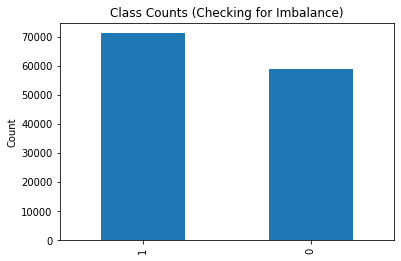

In [11]:
print("Counts of each class")
print(airlineDF[target].value_counts())
airlineDF[target].value_counts().plot(kind='bar')
plt.ylabel('Count')
plt.title('Class Counts (Checking for Imbalance)')
airlineDF.shape

# **<span style="color:	#D400D7;">5. Menghilangkan Missing Values</span>**

In [12]:
print("Percentage of missing: {} %".format(round(airlineDF['Arrival Delay in Minutes'].isnull().sum()/
                                                 airlineDF.shape[0]*100, 3)))

Percentage of missing: 0.303 %


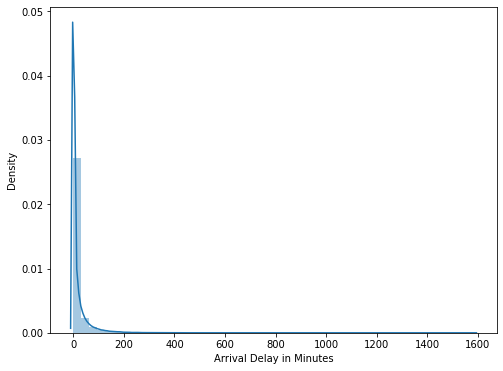

In [13]:
### Kita hanya memiliki missing values pada "Arrival Delay in Minutes" 

fig = plt.figure(figsize=(8,6))
sns.distplot(airlineDF['Arrival Delay in Minutes']); 
plt.show()

# **<span style="color:	#D400D7;">6. Split Dataset ke data latihan, validasi dan tes</span>**

In [14]:
X = airlineDF.drop([target], axis=1) 
y = airlineDF[target]

SEED = 42 
TEST_SIZE = 0.2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, stratify=y, random_state=SEED) 

#### Validasi

In [15]:
SEED = 42 
VAL_SIZE = 0.2 # % dari Data latihan

X_train, X_val, y_train, y_val =  train_test_split(X_train, y_train, test_size=VAL_SIZE, stratify=y_train, random_state=SEED)  

#### Model Dasar: catboost

In [16]:
# Kita dapat mengoptimisasi iterasi, learning rate dan Metrik evaluasi menjadi lebih tinggi
model = CatBoostClassifier(
    iterations=50,
    random_seed=63,
    learning_rate=0.1,
    custom_loss=['Accuracy'],
    eval_metric='Accuracy' 
)

## Ketika kita mencocokkan model dengan parameter plot=True, Kita dapat melihat bagaimana model itu berlatih
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_val, y_val),
    logging_level='Silent',
    plot=True
) 

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

#### Evaluasi pada dataset tes 

In [17]:
score = model.score(X_test, y_test)

print("Test score (accuracy): ", round(score, 3))

Test score (accuracy):  0.934


>Dengan Hiperparameter Basic kita mampu mendapatkan hasil tinggi 93%, itu berarti dataset cukup simpel

#### Penjelasan menggunakan Shap 

> Dimana Features memiliki impact yang lebih besar pada akurasi

In [18]:
import shap

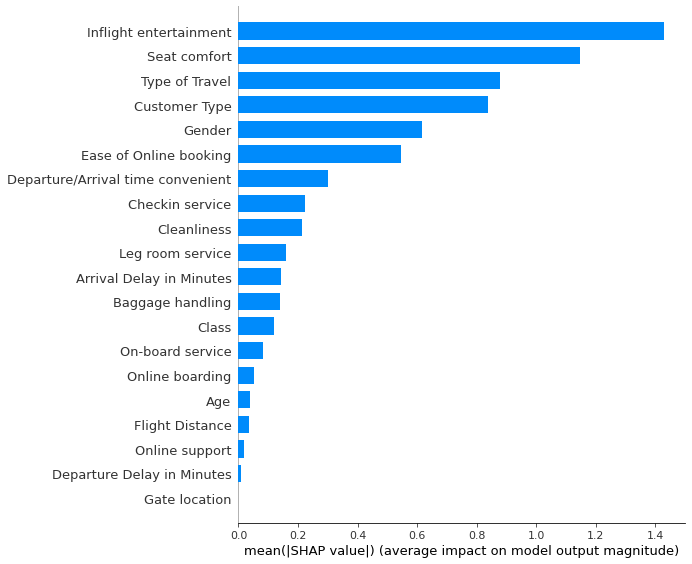

In [19]:
explainer = shap.TreeExplainer(model)  
shap_values = explainer.shap_values(X_test)
base_value = explainer.expected_value
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns, plot_type="bar")

<AxesSubplot:xlabel='Inflight entertainment', ylabel='count'>

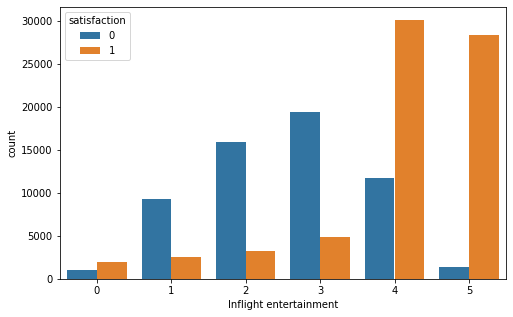

In [20]:
plt.figure(figsize=(8, 5))

x = 'Inflight entertainment'
y = target

sns.countplot(x, hue = y, data = airlineDF) 

> For "Inflight entertainment", passengers with Inflight entertainment score 4 and 5 are mostly satisfied. 

<AxesSubplot:xlabel='Seat comfort', ylabel='count'>

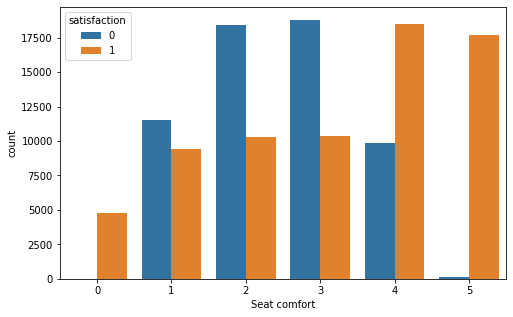

In [21]:
plt.figure(figsize=(8, 5))

x = 'Seat comfort'
y = target

sns.countplot(x, hue = y, data = airlineDF) 

<AxesSubplot:xlabel='Type of Travel', ylabel='count'>

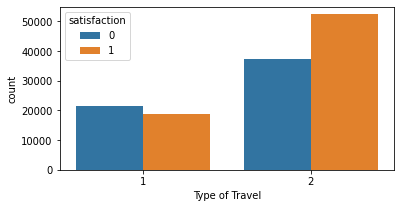

In [22]:
plt.figure(figsize=(6, 3))

x = 'Type of Travel'
y = target

sns.countplot(x, hue = y, data = airlineDF)  

<AxesSubplot:xlabel='Gender', ylabel='count'>

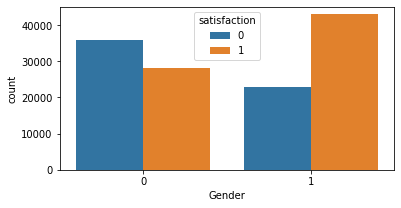

In [23]:
plt.figure(figsize=(6, 3))

x = 'Gender'
y = target

sns.countplot(x, hue = y, data = airlineDF)  

> Dibandingkan dengan laki-laki, Penumpang perempuan memiliki kepuasan yang lebih tinggi

# **<span style="color:	#D400D7;">Terima kasih sudah mampir ke Github Saya, Semoga membantu :)</span>**